In [1]:
from google.colab import files 
uploaded = files.upload()

Saving Beijing.csv to Beijing.csv


In [3]:
import io
import pandas as pd

df_Beijing = pd.read_csv(io.BytesIO(uploaded['Beijing.csv']))
df_Beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [5]:
from datetime import datetime
# Create a new column that is a datetime object
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
# Make index for easy indexing of time values

df_Beijing.set_index('date',inplace=True)
df_Beijing['ds'] = df_Beijing.index

# Only take required fields
df = df_Beijing[["ds",'PM_Dongsi']]
df.rename(columns = {'PM_Dongsi':'y'},inplace=True)

# create a training set and a test set. We are only going to use last month's data to make everything a bit more clear
df_train = df['2015-11']
df_test = df['2015-12':'2015-12-15']
print(df_train.tail())
print(df_test.tail())

                                     ds      y
date                                          
2015-11-30 19:00:00 2015-11-30 19:00:00  685.0
2015-11-30 20:00:00 2015-11-30 20:00:00  685.0
2015-11-30 21:00:00 2015-11-30 21:00:00  638.0
2015-11-30 22:00:00 2015-11-30 22:00:00  548.0
2015-11-30 23:00:00 2015-11-30 23:00:00  490.0
                                     ds    y
date                                        
2015-12-15 19:00:00 2015-12-15 19:00:00  9.0
2015-12-15 20:00:00 2015-12-15 20:00:00  7.0
2015-12-15 21:00:00 2015-12-15 21:00:00  6.0
2015-12-15 22:00:00 2015-12-15 22:00:00  4.0
2015-12-15 23:00:00 2015-12-15 23:00:00  6.0


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
import fbprophet
from fbprophet import Prophet
# fit model
m = Prophet()
m.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [8]:
future = m.make_future_dataframe(periods = 15*24,freq = 'h') # could also leave default freq of days and do 31 for period
print(future.head())
future.tail()

                   ds
0 2015-11-01 00:00:00
1 2015-11-01 01:00:00
2 2015-11-01 02:00:00
3 2015-11-01 03:00:00
4 2015-11-01 04:00:00


,ds
1075,2015-12-15 19:00:00
1076,2015-12-15 20:00:00
1077,2015-12-15 21:00:00
1078,2015-12-15 22:00:00
1079,2015-12-15 23:00:00


In [9]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
1075,2015-12-15 19:00:00,1365.113815,1095.219633,1633.949202
1076,2015-12-15 20:00:00,1367.407170,1080.427352,1657.181620
1077,2015-12-15 21:00:00,1366.220378,1099.673454,1660.320748
1078,2015-12-15 22:00:00,1363.359450,1090.895231,1677.133640
1079,2015-12-15 23:00:00,1360.002443,1090.562360,1662.708129


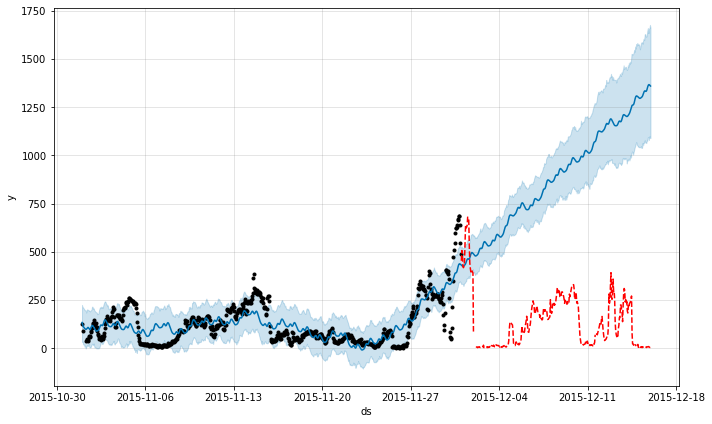

In [11]:
import matplotlib.pyplot as plt

m.plot(forecast)
plt.plot(df_test.y,'r--')

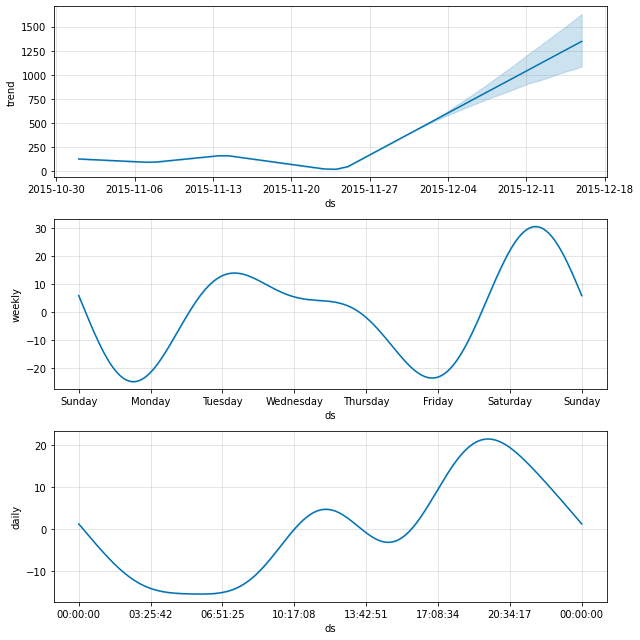

In [13]:
m.plot_components(forecast);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


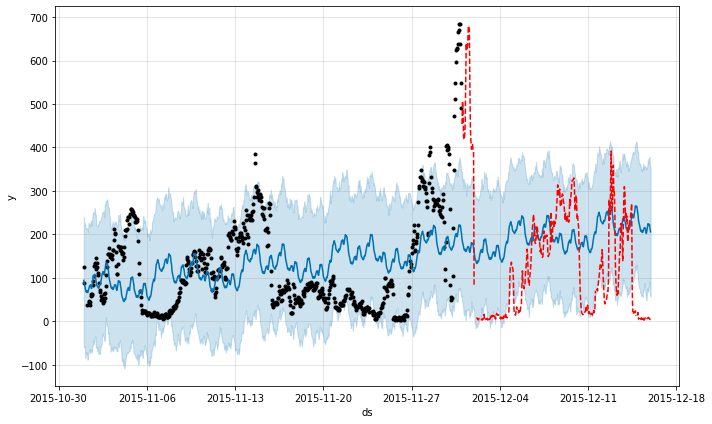

In [14]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.0005
seasonality_prior_scale = 10


m = Prophet(daily_seasonality=10,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(df_train);


forecast = m.predict(future)
m.plot(forecast)
plt.plot(df_test.y,'r--')

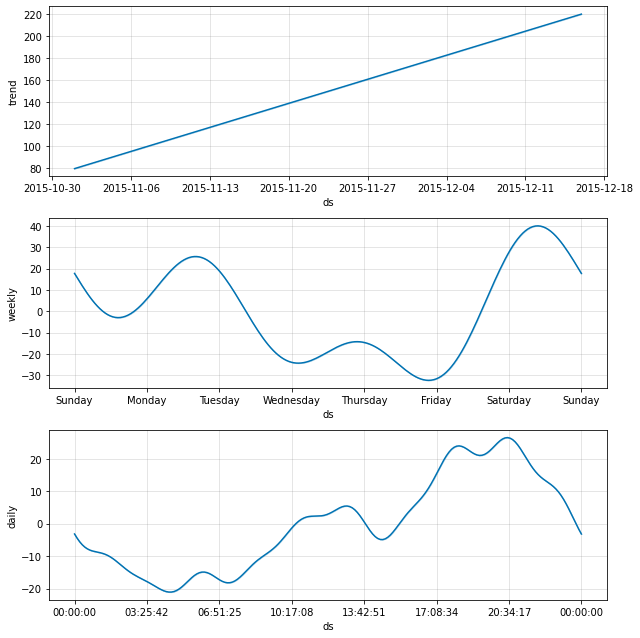

In [15]:
m.plot_components(forecast);